# DS4H - P2 Exploratory Data Analysis

CS 189: Data Science For Health  
Dartmouth College  
Spring 2022  

Franklin, Ke, Spencer

# Project Introduction and Overview

This project is designed to use data from a 2013/2014 NHANES survey to better understand how sleep habits and disorders such as insomnia are related to depression and physical activity for people from a variety of demographics. This data set was collected from around five thousand american people of varying age, sex and background. 

This is the exploratory analysis performed on the NHANES data set collected in 2013/2014. Through this analysis, the reader should be able to understand where the data is coming from, how it's being joined into a single data set by patient_id number, understand the limitations of the data such as missing values, and understand the data distributions. Additionally, we will discuss the strucure of the data that comes from each data source; many sources provide a single value for a patient that came from a survey, but the physical activity data source provides minute-level time series data that was collected from a wearable accelerometer on the patient's wrist for nine days. This EDA notebook also shows some of the segmentation analysis that our team will develop through out this term. 

An overall description of NHANES and the reasoning behind their data collection processes can be found at [their cdc.gov page.](https://www.cdc.gov/nchs/nhanes/participant.htm)

<img src="diagram2.png" alt="figure" width="1000"/>

[NHANES Image Source](https://www.cdc.gov/nchs/nhanes/participant.htm)

# Questions that our team hopes to answer: 

1. **Data segmentation analysis based on demographics**
- How does average sleep, reported depression, or physical activity change with sex or age? 
- Are the prevelence of sleep disorders or severe depression different based on sex or age? 

    **We can also explore segmentation based on physical activity:**
- Do people with lots of physical activity report fewer sleep disorders than people little physical activity? 
- Do people with lots of physical activity report less levels of depression than people little physical activity? 
- Can we use the structure of the signal in the physical activity time series data to answer these questions better than we can by simply taking the mean physical activity score for each patient across the entire week? 

2. Can we use the time series signal from physical activity as the basis for predicting the presence of sleep disorders or depression? This presents a use case for time series classification in which we aim to discern the depression level or sleep habits based on a person's minute-level physical activity.

The first goal of the project is to combine all the survey data, activity time series data, and demographic data for each patient. We will begin by important the data from disk into memory using the python library pandas. 

# Data Sources

## Physical Activity, Sleep Survey, Depression Survey, Demographics

*To run this notebook, place the data files into a directory called 'data' that sits at the same location as this jupyter notebook.*

**Physical Activity Data Source (Days)**: [CDC National Center for Health Statistics](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Examination&CycleBeginYear=2013)

- [Supplimental Information on this data set](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/PAXDAY_H.htm)

**Physical Activity Data Source (Minutes)**: [CDC National Center for Health Statistics](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/PAXMIN_H.htm)

- [Supplimental Information on this data set](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/PAXMIN_H.htm)

**Sleep Survey Data Source**: [CDC National Center for Health Statitics](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&CycleBeginYear=2013)

- [Supplimental Information on this data set](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/SLQ_H.htm)

**Depression Survey Data Source**: [CDC National Center for Health Statitics](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire)

- [Supplimental Information on this data set](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DPQ_H.htm)


**Patient Demographics Data Source**: [CDC National Center for Health Statitics](https://wwwn.cdc.gov/nchs/nhanes/search/DataPage.aspx?Component=Demographics)

- [Supplimental Information on this data set](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.htm)

# Define Notebook Variables

First we want to define whether or not we're using minute-level or hour-level physical activity data: 

In [1]:
phys_data: str = 'hour'  # <-- either 'minute' or 'hour'

# Imports

In [2]:
# Note: 
# If the theme of jupyter lab is in "Dark Mode" you won't be able to see the axis labels
# TO CHANGE THEME --> Settings --> Theme --> JupyterLab (Light/Dark)

from pathlib import Path 
from typing import Dict
import os
import random

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import pandas as pd
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import scipy
import pickle

import pylab as pl
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
from matplotlib_venn import venn2, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
plt.style.use("fivethirtyeight")
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import seaborn as sns

# Load the data using pandas

Each specific data source can be seen above. The data sets were downloaded locally, and can now be loaded into memory using the pandas python library.

In [3]:
p: str = os.path.abspath('')
base_path: str = p[:-10] + '/data/'
print(f'Data files should be in the following directory: {base_path}')

Data files should be in the following directory: /Users/spencerbertsch/Desktop/dev/DS4H/data/


## Load the physical activity data
Here we will load the physical activity time series data that will tell us about the movement of each person in the study. 

- Note this is time series data aggregated by day, hour, or minute. This is unlike the rest of the data sources which are surveys. 

In [4]:
df_active_path: str = base_path + 'PAXDAY_H.XPT'
df_active: pd.DataFrame = pd.read_sas(df_active_path)
df_active = round(df_active, 6)
df_active.head(5)

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0
3,73557.0,b'4',b'6',15984000.0,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,0.0,0.0,1439.0,1.0,0.00,0.0
4,73557.0,b'5',b'7',22896000.0,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,38649.85,0.0


## Load the sleep data

Here we will load the survey data that asks patients questions such as:  
- How many hours per night do you usually sleep?
- Do you have a sleep disorder? 
- Do you have trouble sleeping? 

In [5]:
df_sleep_path: str = base_path + 'SLQ_H.XPT'
df_sleep: pd.DataFrame = pd.read_sas(df_sleep_path)
df_sleep = round(df_sleep, 6)
df_sleep.head(5)

,SEQN,SLD010H,SLQ050,SLQ060
0,73557.0,7.0,1.0,2.0
1,73558.0,9.0,2.0,2.0
2,73559.0,8.0,2.0,2.0
3,73561.0,9.0,2.0,2.0
4,73562.0,5.0,2.0,1.0


We know from [this source](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/SLQ_H.htm) that if the sleep hours feature is over 12, then the person chose not to respond to the survey. Similarly, we can remove the bad samples from the other sleep survey features as well.

In [6]:
df_sleep = df_sleep[df_sleep['SLD010H'] <= 12]
df_sleep = df_sleep[df_sleep['SLQ050'] <= 2]
df_sleep = df_sleep[df_sleep['SLQ060'] <= 2]

## Load the depression survey data

Here we will load the survey data that asks patients questions such as:  
- Have little interest in doing things?
- Feeling down, depressed, or hopeless? 
- Thought you would be better off dead? 

In [7]:
df_depression_path: str = base_path + 'DPQ_H.XPT'
df_depression: pd.DataFrame = pd.read_sas(df_depression_path)
df_depression = round(df_depression, 6)
df_depression.head()

,SEQN,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
0,73557.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,73558.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,73559.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,73561.0,2.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0
4,73562.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,3.0


## Load the demographic survey data

Here we will load the survey data that asks patients questions such as:  
- What is your gender? 
- What is your age in years? 
- What is your education level? 
- What is your marital status? 

In [8]:
df_demographic_path: str = base_path + 'DEMO_H.XPT'
df_demographic: pd.DataFrame = pd.read_sas(df_demographic_path)
df_demographic = round(df_demographic, 6)
df_demographic.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGE,DMDHRBR4,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,73557.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84
1,73558.0,8.0,2.0,1.0,54.0,NaN,3.0,3.0,1.0,NaN,2.0,NaN,1.0,1.0,NaN,NaN,3.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,4.0,4.0,0.0,2.0,0.0,1.0,54.0,1.0,3.0,1.0,1.0,23682.057386,24471.769625,1.0,108.0,7.0,7.0,1.78
2,73559.0,8.0,2.0,1.0,72.0,NaN,3.0,3.0,2.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,4.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,NaN,2.0,2.0,0.0,0.0,2.0,1.0,72.0,1.0,4.0,1.0,3.0,57214.803319,57193.285376,1.0,109.0,10.0,10.0,4.51
3,73560.0,8.0,2.0,1.0,9.0,NaN,3.0,3.0,1.0,119.0,NaN,NaN,1.0,1.0,NaN,3.0,NaN,NaN,NaN,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,4.0,4.0,0.0,2.0,0.0,1.0,33.0,1.0,3.0,1.0,4.0,55201.178592,55766.512438,2.0,109.0,9.0,9.0,2.52
4,73561.0,8.0,2.0,2.0,73.0,NaN,3.0,3.0,1.0,NaN,2.0,NaN,1.0,1.0,NaN,NaN,5.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,NaN,2.0,2.0,0.0,0.0,2.0,1.0,78.0,1.0,5.0,1.0,5.0,63709.667069,65541.871229,2.0,116.0,15.0,15.0,5.00


# Load the subset of minute-level activity data

In [9]:
df_minute_activity_path: str = base_path + 'two_patients_minute_data.csv'
df_minute_activity: pd.DataFrame = pd.read_csv(df_minute_activity_path)
df_minute_activity = round(df_minute_activity, 6)
df_minute_activity = df_minute_activity.drop(['Unnamed: 0'], axis=1)
df_minute_activity.head()

,SEQN,PAXDAYM,PAXDAYWM,PAXSSNMP,PAXTSM,PAXAISMM,PAXMTSM,PAXMXM,PAXMYM,PAXMZM,PAXPREDM,PAXTRANM,PAXLXSM,PAXLXSDM,PAXQFM,PAXFLGSM
0,73557.0,b'1',b'3',0.0,60.0,0.0,17.112,6.785,3.513,6.814,b'1',b'0',1755.17,884.07,0.0,b''
1,73557.0,b'1',b'3',4800.0,60.0,0.0,14.366,5.222,4.117,5.027,b'1',b'0',2267.79,441.48,0.0,b''
2,73557.0,b'1',b'3',9600.0,60.0,0.0,5.856,1.588,2.160,2.108,b'1',b'0',2464.71,253.51,0.0,b''
3,73557.0,b'1',b'3',14400.0,60.0,0.0,13.570,4.482,3.529,5.558,b'1',b'0',2419.58,189.84,0.0,b''
4,73557.0,b'1',b'3',19200.0,60.0,0.0,10.862,3.619,2.429,4.814,b'1',b'0',1877.48,572.88,0.0,b''


In [10]:
[col for col in df_minute_activity.columns]

['SEQN',
 'PAXDAYM',
 'PAXDAYWM',
 'PAXSSNMP',
 'PAXTSM',
 'PAXAISMM',
 'PAXMTSM',
 'PAXMXM',
 'PAXMYM',
 'PAXMZM',
 'PAXPREDM',
 'PAXTRANM',
 'PAXLXSM',
 'PAXLXSDM',
 'PAXQFM',
 'PAXFLGSM']

### Run the below cell if we want to use minute-level activity data instead of daily activity data

In [11]:
if phys_data == 'minute':
    df_active: pd.DataFrame = df_minute_activity
elif phys_data == 'hour':
    # this is assigned by default
    pass
else:
    raise Exception(f'phys_data should be either \'minute\' or \'hour\', not {phys_data}')

## Data Processing upon loading 

We can immediately see some light processing that we need to apply to use this data including the fact that the values in the physical activity data can be as small as 5.397605e-79, meaning that we need to round these values to some reasonable digit before continuing. That's why the line was added to each data loading cell that rounds the value to the nearest 6th decimal. 

# Initial Observations and Overview

The first step in EDA is to simply read all the documentation and actually understand the data set. Here we have physical activity data that was collected over time for a group of patients, and sleep data that was collected once for each patient via a survey. After joining these two data souurces together, we will have a data set with the following structure depending on the frequency of the physical activity data:



<img src="diagram_new.png" alt="figure" width="800"/>

This is a list of gradients that makes for nice plots

In [12]:
hex_colors: list = [
    # blue 
    '#42A5F5', '#2196F3', '#1E88E5', '#1976D2', '#1565C0', 
    # light purple 
    '#7E57C2', '#673AB7', '#5E35B1', '#512DA8', '#4527A0', 
    # dark purple 
    '#AB47BC', '#9C27B0', '#8E24AA', '#7B1FA2', '#6A1B9A'
]

### How many of the patients belong to both of the data sets? 

We can answer this question by creating a venn diagram showing the number of patients that belong to each of the sets. 

<img src="diagram3.png" alt="figure" width="550"/>

In [13]:
physical_activity_patient_ids: set = set(df_active['SEQN'])

In [14]:
sleep_patient_ids: set = set(df_sleep['SEQN'])

In [15]:
def create_venn_2_sets(set1: set, set2: set, set1_name: str, set2_name: str):
    """
    This function can be used to create a venndiagram using two distinct sets of values. This function can be extended easily using the 'venn3' 
    library built using Matplotlib so that venn diagrams of 3 sets can be generated. 
    """
    figure(figsize=(6, 6), dpi=80)
    venn2_unweighted([set1, set2], 
          (set1_name, set2_name), 
          set_colors=('purple', 'skyblue'), 
          alpha = 0.7)
    plt.show()

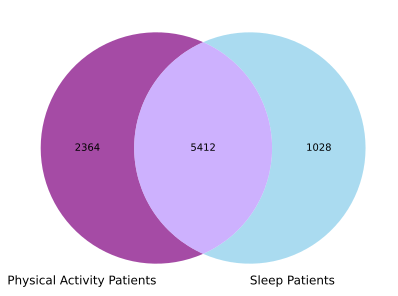

In [16]:
create_venn_2_sets(set1=physical_activity_patient_ids, set2=sleep_patient_ids, set1_name='Physical Activity Patients', set2_name='Sleep Patients')

This venn diagram shows us the set intersection betwen the patients included in each of the data sets that we're going to use. Our goal here is to combine the physical activity data and teh sleep data together, but we can only perform the join on **patient_id**. This plot shows us that even though we are losing 2,344 physical activity patients who don't have sleep data and 1,032 sleep patents who don't have physical activity data, we still have 5,432 patients to use in our analysis. 

## We can also look at the intersecting sets for the actigraphy, sleep, and depression data sets

In [17]:
depression_patient_ids: set = set(df_depression['SEQN'])
demographic_patient_ids: set = set(df_demographic['SEQN'])

In [18]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted

def venn_3_diagram(set1: set, set2: set, set3: set, set1_name: str, set2_name: str, set3_name: str, color_scheme: int):
    """
    This function takes three sets and three strings (labels for each set) and plots the 3-way venn diagram of the set intersections. 
    """
    
    if color_scheme == 1:
        colors: tuple = ('purple', 'skyblue', 'red')
    else: 
        colors: tuple = ('purple', 'skyblue', 'darkorange')
    
    figure(figsize=(7, 7), dpi=80)
    venn3_unweighted([set1, set2, set3], 
                     (set1_name, set2_name, set3_name), 
                     set_colors=colors, 
                     alpha = 0.6)

    plt.show()

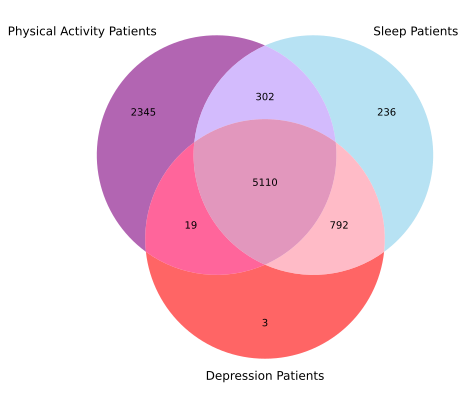

In [19]:
venn_3_diagram(set1=physical_activity_patient_ids, set1_name='Physical Activity Patients',
               set2=sleep_patient_ids, set2_name='Sleep Patients',
               set3=depression_patient_ids, set3_name='Depression Patients', color_scheme=1)

## Only lost 302 Patients, 5,110 patients remain in the data set

Great! So we can see from the above venn diagram that there are only 302 patients that have both physical activity data and sleep data, but not depression data. This leaves us with a total data set size of 5,110 patients. 

Now the only thing left to check is how many patients we will lose (if any) if we also perform an inner join on the demographic data.

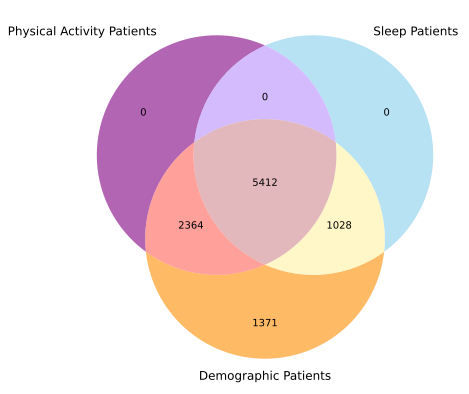

In [20]:
venn_3_diagram(set1=physical_activity_patient_ids, set1_name='Physical Activity Patients',
               set2=sleep_patient_ids, set2_name='Sleep Patients',
               set3=demographic_patient_ids, set3_name='Demographic Patients',
               color_scheme=2)

## Lost 0 patients, 5,110 patients remain in the data set

Perfect! We can see that there aren't any patients that submitted physical activity and sleep data that didn't also submit demographic data. That means that an inner join on the demographic data won't result in us losing any patients.

# Join the physical activity and sleep data together 

At this point we can now perform an inner join to merge these two data sets together

In [21]:
df_joined1 = df_active.merge(df_sleep, left_on='SEQN', right_on='SEQN')
num_unique = len(df_joined1['SEQN'].unique())
print(f'Number of unique patients in the resulting data set: {num_unique} individual patients.')

Number of unique patients in the resulting data set: 5412 individual patients.


In [22]:
df_joined1.head(3)

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD,SLD010H,SLQ050,SLQ060
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0,7.0,1.0,2.0
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0,7.0,1.0,2.0
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0,7.0,1.0,2.0


# Join the new data set with the depression data set

At this point we can now perform an inner join to merge the joined data set defined above with the depression data set

In [23]:
df_joined2 = df_joined1.merge(df_depression, left_on='SEQN', right_on='SEQN')
num_unique = len(df_joined2['SEQN'].unique())
print(f'Number of unique patients in the resulting data set: {num_unique} individual patients.')

Number of unique patients in the resulting data set: 5110 individual patients.


In [24]:
df_joined2.head(3)

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD,SLD010H,SLQ050,SLQ060,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Join the new data set with the demographics data set

At this point we can now perform an inner join to merge the joined data set defined above with the demographics data set

In [25]:
df_joined3 = df_joined2.merge(df_demographic, left_on='SEQN', right_on='SEQN')
num_unique = len(df_joined3['SEQN'].unique())
print(f'Number of unique patients in the resulting data set: {num_unique} individual patients.')

Number of unique patients in the resulting data set: 5110 individual patients.


In [26]:
df_joined3.head(3)

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD,SLD010H,SLQ050,SLQ060,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGE,DMDHRBR4,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84


So now we have joined all the data sources together by patient_id. Great, so now we can move on to rename the columns so that they're human-readable. After that we can begin examining the structure of the data itself to see what's missing, examining distributions, etc. 

# Rename the columns in the dataframe to human-readable names

It's easy to see by inspection that each of the columns in the joined data set have a code as their title. 

The *patient_id* column, for example, is called *SEQN*. Now it's time that we rename all of the columns to more human-readable strings so that anyone looking at analysis or plots will be able to intuitively see the meaning in each result. 

## Use a dictionary to rename all the columns

In [27]:
renamer: dict = {
                 # JOIN COLUMN
                 'SEQN': 'patient_id', 
                 
                 # PHYSICAL ACTIVITY DATA
                 'PAXDAYD': 'day',
                 'PAXDAYWD': 'day_of_week',
                 'PAXSSNDP': 'start_num',
                 'PAXMSTD': 'start_time',
                 'PAXTMD': 'total_collection_time',
                 'PAXAISMD': 'sleep_mode_measurements',
                 'PAXVMD': 'valid_data_minutes',
                 'PAXMTSD': '3d_acceleration',
                 'PAXWWMD': 'minutes_awake',
                 'PAXSWMD': 'minutes_asleep',
                 'PAXNWMD': 'minutes_not_worn',
                 'PAXUMD': 'minutes_no_data',
                 'PAXLXSD': 'ambient_light_measure',
                 'PAXQFD': 'data_quality_flag',
    
                 # MINUTE LEVEL PHYSICAL ACTVITY DATA
                 'PAXDAYM': 'day_of_pam_measurements',
                 'PAXDAYWM': 'day_of_week',
                 'PAXSSNMP': 'starting_sample_number',
                 'PAXTSM': 'total_seconds_with_data',
                 'PAXAISMM': 'idle_sleep_mode_minutes',
                 'PAXMTSM': 'triaxial_acceleration',
                 'PAXMXM': 'x_axis_acceleration',
                 'PAXMYM': 'y_axis_acceleration',
                 'PAXMZM': 'z_axis_acceleration',
                 'PAXPREDM': 'awake_or_asleep_minute',
                 'PAXTRANM': 'awake_asleep_transition_flag',
                 'PAXLXSM': 'light_value_over_minute',
                 'PAXLXSDM': 'std_ of_light_value_over_minute',
                 'PAXQFM': 'data_quality_flag_cnt',
                 'PAXFLGSM': 'quality_flags_triggered',
                 
                 # SLEEP DATA
                 'SLD010H': 'sleep_hours', 
                 'SLQ050':'trouble_sleeping', 
                 'SLQ060':'sleep_disorder',
    
                 # DEPRESSION DATA
                 'DPQ010': 'no_interest', 
                 'DPQ020': 'down_or_hopeless', 
                 'DPQ030': 'sleep_problems', 
                 'DPQ040': 'tired_no_energy', 
                 'DPQ050': 'eating_problems', 
                 'DPQ060': 'self_loathing',
                 'DPQ070': 'trouble_concentrating', 
                 'DPQ080': 'trouble_moving', 
                 'DPQ090': 'better_off_dead', 
                 'DPQ100': 'depression_problems',
    
                 # DEMOGRAPHIC DATA
                'SDDSRVYR': 'release_cycle', 
                'RIDSTATR': 'exam_status', 
                'RIAGENDR': 'gender', 
                'RIDAGEYR': 'age_years', 
                'RIDAGEMN': 'age_months',
                'RIDRETH1': 'race_hispanic',
                'RIDRETH3': 'race_hispanic_asian',
                'RIDEXMON': 'six_month_period',
                'RIDEXAGM': 'age_in_months_teens',
                'DMQMILIZ': 'served_in_armed_forces',
                'DMQADFC': 'served_in_foreign_country',
                'DMDBORN4': 'country_of_birth',
                'DMDCITZN': 'citizenship', 
                'DMDYRSUS': 'length_of_time_in_usa', 
                'DMDEDUC3': 'education_level_youth', 
                'DMDEDUC2': 'education_level_adult', 
                'DMDMARTL': 'marital_status',
                'RIDEXPRG': 'pregnancy_status',
                'SIALANG': 'language_of_interview', 
                'SIAPROXY': 'proxy_used_in_interview', 
                'SIAINTRP': 'interpreter_used_in_interview', 
                'FIALANG': 'language_family_interview', 
                'FIAPROXY': 'proxy_family_interview',
                'FIAINTRP': 'interpreter_used_in_family_interview',
                'MIALANG': 'language_of_memc_interview', 
                'MIAPROXY': 'proxy_used_in_memc_interview', 
                'MIAINTRP': 'interpreter_used_in_MEMC_interview', 
                'AIALANGA': 'language_of_asci_interview', 
                'DMDHHSIZ': 'num_people_in_household',
                'DMDFMSIZ': 'num_people_in_family',
                'DMDHHSZA': 'num_children_below_5_in_household', 
                'DMDHHSZB': 'num_children_6_to_17_in_household', 
                'DMDHHSZE': 'num_60_plus_in_household', 
                'DMDHRGND': 'hh_ref_gender', 
                'DMDHRAGE': 'hh_ref_age_years',
                'DMDHRBR4': 'hh_ref_country_of_birth',
                'DMDHREDU': 'hh_ref_education_level', 
                'DMDHRMAR': 'hh_ref_marital_status', 
                'DMDHSEDU': 'hh_ref_spouse_education_level', 
                'WTINT2YR': '2_year_interview_weight', 
                'WTMEC2YR': '2_year_MEMC_weight',
                'SDMVPSU': 'masked_variance_pseudo_PSU', 
                'SDMVSTRA': 'masked_variance_pseudostratum', 
                'INDHHIN2': 'annual_household_income', 
                'INDFMIN2': 'annual_family_income', 
                'INDFMPIR': 'income_poverty_ratio'
                }

In [28]:
df_joined = df_joined3.rename(columns=renamer)
df_joined.head()

,patient_id,day,day_of_week,start_num,start_time,total_collection_time,sleep_mode_measurements,valid_data_minutes,3d_acceleration,minutes_awake,minutes_asleep,minutes_not_worn,minutes_no_data,ambient_light_measure,data_quality_flag,sleep_hours,trouble_sleeping,sleep_disorder,no_interest,down_or_hopeless,sleep_problems,tired_no_energy,eating_problems,self_loathing,trouble_concentrating,trouble_moving,better_off_dead,depression_problems,release_cycle,exam_status,gender,age_years,age_months,race_hispanic,race_hispanic_asian,six_month_period,age_in_months_teens,served_in_armed_forces,served_in_foreign_country,country_of_birth,citizenship,length_of_time_in_usa,education_level_youth,education_level_adult,marital_status,pregnancy_status,language_of_interview,proxy_used_in_interview,interpreter_used_in_interview,language_family_interview,proxy_family_interview,interpreter_used_in_family_interview,language_of_memc_interview,proxy_used_in_memc_interview,interpreter_used_in_MEMC_interview,language_of_asci_interview,num_people_in_household,num_people_in_family,num_children_below_5_in_household,num_children_6_to_17_in_household,num_60_plus_in_household,hh_ref_gender,hh_ref_age_years,hh_ref_country_of_birth,hh_ref_education_level,hh_ref_marital_status,hh_ref_spouse_education_level,2_year_interview_weight,2_year_MEMC_weight,masked_variance_pseudo_PSU,masked_variance_pseudostratum,annual_household_income,annual_family_income,income_poverty_ratio
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84
3,73557.0,b'4',b'6',15984000.0,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,0.0,0.0,1439.0,1.0,0.00,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84
4,73557.0,b'5',b'7',22896000.0,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,38649.85,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84


### Optionally save the data at this stage for use in other notebooks:

In [29]:
# df_joined.to_csv('data_all_features_hourly.csv', sep=',')

# pickle_out = open("data_all_features_hourly.pickle", "wb")
# pickle.dump(df_joined, pickle_out)
# pickle_out.close()

### Define numeric columns for histograms

In [30]:
cols = ['patient_id',  'day', 'day_of_week', 'start_num', 'start_time', 'total_collection_time', 'sleep_mode_measurements', \
        'valid_data_minutes', '3d_acceleration', 'minutes_awake', 'minutes_asleep', 'minutes_not_worn', 'minutes_no_data', \
        'ambient_light_measure', 'data_quality_flag', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']

numeric_cols = ['patient_id', 'start_num', 'total_collection_time', 'sleep_mode_measurements', \
                'valid_data_minutes', '3d_acceleration', 'minutes_awake', 'minutes_asleep', 'minutes_not_worn', 'minutes_no_data', \
                'ambient_light_measure', 'data_quality_flag', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']

# define numeric cols for the minute data
numeric_cols = ['patient_id', 'starting_sample_number', 'triaxial_acceleration', 'x_axis_acceleration', 'y_axis_acceleration', 'z_axis_acceleration', 
                'sleep_mode_measurements', 'light_value_over_minute', \
                'valid_data_minutes', '3d_acceleration', 'minutes_awake', 'minutes_asleep', 'minutes_not_worn', 'minutes_no_data', \
                'ambient_light_measure', 'data_quality_flag', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']

### Define Fields of Interest

We now have a large number of columns in our table: 76. In order to make the analysis faster, especially when using all 5,110 patients in the joined data set, we can subset the columns to a handful of columns that matter the most. 

In [31]:
if phys_data == 'minute':
    fields_of_interest = [
    'patient_id', 
    'triaxial_acceleration',
    'x_axis_acceleration',
    'y_axis_acceleration',
    'z_axis_acceleration',
    'awake_or_asleep_minute',
    'sleep_hours', 
    'trouble_sleeping', 
    'sleep_disorder',
    'no_interest', 
    'down_or_hopeless', 
    'sleep_problems', 
    'tired_no_energy', 
    'eating_problems', 
    'self_loathing',
    'trouble_concentrating', 
    'trouble_moving', 
    'better_off_dead', 
    'depression_problems',
    'gender', 
    'age_years', 
    'served_in_armed_forces', 
    'country_of_birth', 
    'citizenship', 
    'marital_status', 
    'num_people_in_household', 
    'annual_household_income'
    ]
elif phys_data == 'hour':
    fields_of_interest = [
    'patient_id', 
    'sleep_mode_measurements',
    'valid_data_minutes', 
    '3d_acceleration', 
    'minutes_awake', 
    'minutes_asleep', 
    'minutes_not_worn', 
    'minutes_no_data', 
    'sleep_hours', 
    'trouble_sleeping', 
    'sleep_disorder',
    'no_interest', 
    'down_or_hopeless', 
    'sleep_problems', 
    'tired_no_energy', 
    'eating_problems', 
    'self_loathing',
    'trouble_concentrating', 
    'trouble_moving', 
    'better_off_dead', 
    'depression_problems',
    'gender', 
    'age_years', 
    'served_in_armed_forces', 
    'country_of_birth', 
    'citizenship', 
    'marital_status', 
    'num_people_in_household', 
    'annual_household_income'
    ]
else:
    raise Exception(f'phys_data should be either \'minute\' or \'hour\', not {phys_data}')

# Explore missing data for each data set

In [32]:
df_filtered = df_joined[fields_of_interest]
df_filtered.head(5)

,patient_id,sleep_mode_measurements,valid_data_minutes,3d_acceleration,minutes_awake,minutes_asleep,minutes_not_worn,minutes_no_data,sleep_hours,trouble_sleeping,sleep_disorder,no_interest,down_or_hopeless,sleep_problems,tired_no_energy,eating_problems,self_loathing,trouble_concentrating,trouble_moving,better_off_dead,depression_problems,gender,age_years,served_in_armed_forces,country_of_birth,citizenship,marital_status,num_people_in_household,annual_household_income
0,73557.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,69.0,1.0,1.0,1.0,4.0,3.0,4.0
1,73557.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,69.0,1.0,1.0,1.0,4.0,3.0,4.0
2,73557.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,69.0,1.0,1.0,1.0,4.0,3.0,4.0
3,73557.0,6860400.0,1440.0,23.641,0.0,0.0,1439.0,1.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,69.0,1.0,1.0,1.0,4.0,3.0,4.0
4,73557.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,69.0,1.0,1.0,1.0,4.0,3.0,4.0


In [33]:
df_filtered = df_joined[fields_of_interest]

In [34]:
df_filtered.isnull().sum()

patient_id                     0
sleep_mode_measurements        0
valid_data_minutes             0
3d_acceleration                0
minutes_awake                  0
minutes_asleep                 0
minutes_not_worn               0
minutes_no_data                0
sleep_hours                    0
trouble_sleeping               0
sleep_disorder                 0
no_interest                 2898
down_or_hopeless            2916
sleep_problems              2925
tired_no_energy             2925
eating_problems             2925
self_loathing               2934
trouble_concentrating       2934
trouble_moving              2934
better_off_dead             2943
depression_problems        16485
gender                         0
age_years                      0
served_in_armed_forces         0
country_of_birth               0
citizenship                   18
marital_status              2532
num_people_in_household        0
annual_household_income      569
dtype: int64

In [35]:
df_filtered.isnull().sum().sum()

45938

### How are the physical activity measurements correlated to the sleep values across patients? 

We can answer this question by grouping each cluster of physical activity values to get the mean value for each patient, then generating a correlation matrix to see how each fearure is correlated with the sleep featuers. 

In [36]:
df_to_group = df_joined[fields_of_interest]
df_grouped: pd.DataFrame = df_to_group.groupby('patient_id').mean()
df_grouped['patient_id'] = df_grouped.index
df_grouped.head()

,sleep_mode_measurements,valid_data_minutes,3d_acceleration,minutes_awake,minutes_asleep,minutes_not_worn,minutes_no_data,sleep_hours,trouble_sleeping,sleep_disorder,no_interest,down_or_hopeless,sleep_problems,tired_no_energy,eating_problems,self_loathing,trouble_concentrating,trouble_moving,better_off_dead,depression_problems,gender,age_years,served_in_armed_forces,country_of_birth,citizenship,marital_status,num_people_in_household,annual_household_income,patient_id
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73557.0,3.997156e+06,1281.000000,6369.495333,350.777778,82.777778,833.555556,13.888889,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,69.0,1.0,1.0,1.0,4.0,3.0,4.0,73557.0
73558.0,2.742481e+06,1280.666667,8307.157778,678.555556,383.333333,158.000000,60.777778,9.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,54.0,2.0,1.0,1.0,1.0,4.0,7.0,73558.0
73559.0,3.228436e+06,1281.000000,8005.963333,658.888889,511.111111,43.555556,67.444444,8.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,72.0,1.0,1.0,1.0,1.0,2.0,10.0,73559.0
73561.0,2.305937e+06,1280.666667,6470.660889,680.111111,501.000000,25.777778,73.777778,9.0,2.0,2.0,2.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,73.0,2.0,1.0,1.0,1.0,2.0,15.0,73561.0
73562.0,2.637164e+06,1279.666667,14613.943222,836.333333,385.111111,0.000000,58.222222,5.0,2.0,1.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,3.0,1.0,56.0,1.0,1.0,1.0,3.0,1.0,9.0,73562.0


Now that we have the grouped dataframe we can generate the correlation matrix and use a heatmap to visualize it. 

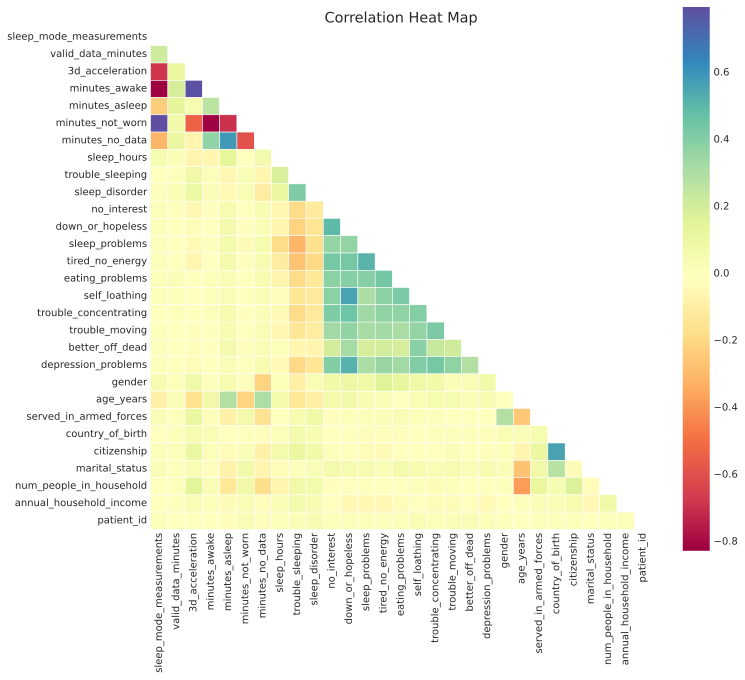

In [37]:
corr = df_grouped.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr, mask=mask, square=True, cmap="Spectral", linewidths=0.5).set_title('Correlation Heat Map')

Some of the physical activity data are highly coelated - either positively or negatively - but there isn't a strong positive or negative correlation between any of the physical activity features and the sleep features. 

We know that each patient has a week's worth of time series physical activity data, so we can also plot a few of the samples to see what they look like.

In [38]:
single_patient_df: pd.DataFrame = df_joined[df_joined['patient_id'] == 73557.0]
single_patient_df.head()

,patient_id,day,day_of_week,start_num,start_time,total_collection_time,sleep_mode_measurements,valid_data_minutes,3d_acceleration,minutes_awake,minutes_asleep,minutes_not_worn,minutes_no_data,ambient_light_measure,data_quality_flag,sleep_hours,trouble_sleeping,sleep_disorder,no_interest,down_or_hopeless,sleep_problems,tired_no_energy,eating_problems,self_loathing,trouble_concentrating,trouble_moving,better_off_dead,depression_problems,release_cycle,exam_status,gender,age_years,age_months,race_hispanic,race_hispanic_asian,six_month_period,age_in_months_teens,served_in_armed_forces,served_in_foreign_country,country_of_birth,citizenship,length_of_time_in_usa,education_level_youth,education_level_adult,marital_status,pregnancy_status,language_of_interview,proxy_used_in_interview,interpreter_used_in_interview,language_family_interview,proxy_family_interview,interpreter_used_in_family_interview,language_of_memc_interview,proxy_used_in_memc_interview,interpreter_used_in_MEMC_interview,language_of_asci_interview,num_people_in_household,num_people_in_family,num_children_below_5_in_household,num_children_6_to_17_in_household,num_60_plus_in_household,hh_ref_gender,hh_ref_age_years,hh_ref_country_of_birth,hh_ref_education_level,hh_ref_marital_status,hh_ref_spouse_education_level,2_year_interview_weight,2_year_MEMC_weight,masked_variance_pseudo_PSU,masked_variance_pseudostratum,annual_household_income,annual_family_income,income_poverty_ratio
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84
3,73557.0,b'4',b'6',15984000.0,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,0.0,0.0,1439.0,1.0,0.00,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84
4,73557.0,b'5',b'7',22896000.0,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,38649.85,0.0,7.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,4.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.0,69.0,1.0,3.0,4.0,NaN,13281.237386,13481.042095,1.0,112.0,4.0,4.0,0.84


In [39]:
def plot_physical_activity_for_single_patient(signals_to_plot: list, save_fig: bool = False):
    """
    Function to generate line graphs representing the minute-to-minute physical activity of the subject for eight days. 
    :param: signals_to_plot - list containing all the column names for signals to plot 
    :return: NA - only renders a plot, returns nothing. 
    """
    fig, axs = plt.subplots(len(signals_to_plot), figsize=(12, 15))
    # fig.suptitle('Physical Activity Signals for a Single Patient', fontsize=12)
    
    for i, feature in enumerate(signals_to_plot):
        axs[i].plot(single_patient_df.index, single_patient_df[signals_to_plot[i]], color=random.choice(hex_colors), linewidth=1.0)

    for i, ax in enumerate(axs.flat):
        ax.set(ylabel=signals_to_plot[i])
        
    if save_fig:
        # save the figure locally as an SVG
        fig.tight_layout()
        fig.savefig('minute_activity.pdf', format='pdf', pad_inches=5) 

    ax.set(xlabel='Time (Minutes over one week)')

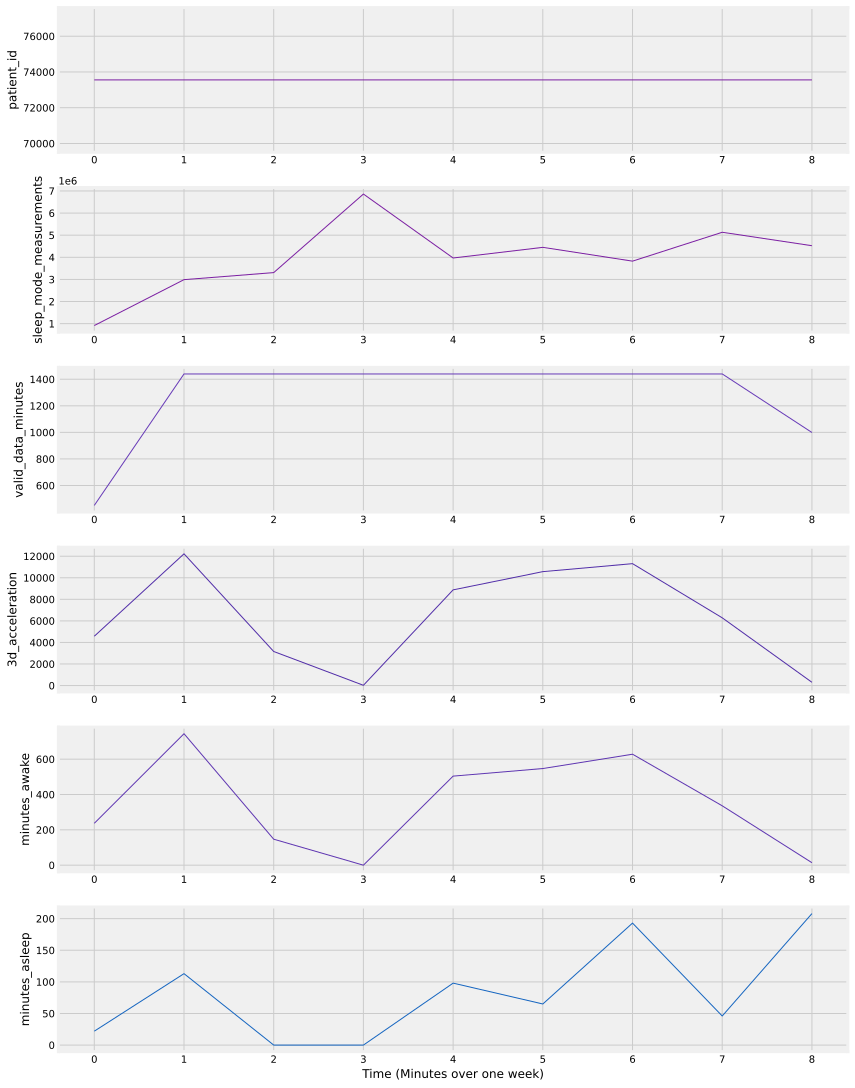

In [40]:
if phys_data == 'minute':
    plot_physical_activity_for_single_patient(save_fig=True, signals_to_plot = ['triaxial_acceleration', 'x_axis_acceleration', \
                                                             'y_axis_acceleration', 'z_axis_acceleration', 'light_value_over_minute'])
elif phys_data == 'hour':
    plot_physical_activity_for_single_patient(save_fig=True, signals_to_plot = ['patient_id', 'sleep_mode_measurements', 'valid_data_minutes', \
                                                                                '3d_acceleration', 'minutes_awake', 'minutes_asleep'])
else:
    raise Exception(f'phys_data should be either \'minute\' or \'hour\', not {phys_data}')

We can see here that each time series presents a unique signal, giving us a rich data environment to work with for applications such as forecasting or time series classification.

We can also look at the distribution of each of the features individually - in order to do this we use a histogram:

In [41]:
phys_data == 'hour'

True

In [42]:
if phys_data == 'minute':
    physical_activity_features = ['patient_id', 'triaxial_acceleration', 'x_axis_acceleration', 'y_axis_acceleration', 'z_axis_acceleration', 'light_value_over_minute']
elif phys_data == 'hour':
    physical_activity_features = ['patient_id',  'day', 'day_of_week', 'start_num', 'start_time', 'total_collection_time', \
                                  'sleep_mode_measurements', 'valid_data_minutes', '3d_acceleration', 'minutes_awake', 'minutes_asleep', \
                                  'minutes_not_worn', 'minutes_no_data', 'ambient_light_measure', 'data_quality_flag']
else:
    raise Exception(f'phys_data should be either \'minute\' or \'hour\', not {phys_data}')

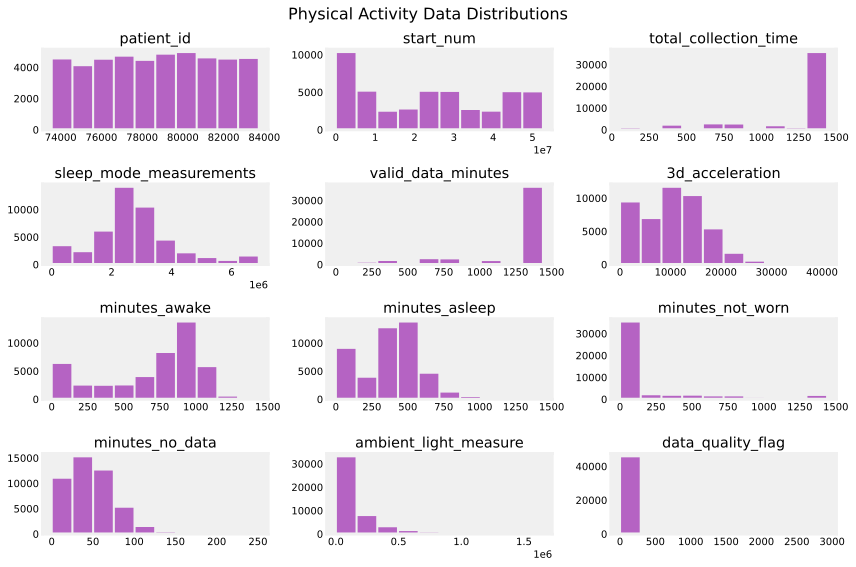

In [43]:
df_joined[physical_activity_features].hist(
    bins=10,
    figsize=(12, 8),
    grid = False,
    rwidth = 0.9,
    alpha=0.7,
    color=random.choice(hex_colors)
)
pl.suptitle("Physical Activity Data Distributions", fontsize=16)
plt.tight_layout()
plt.show()

In [44]:
sleep_features = ['patient_id',  'sleep_hours', 'trouble_sleeping', 'sleep_disorder']

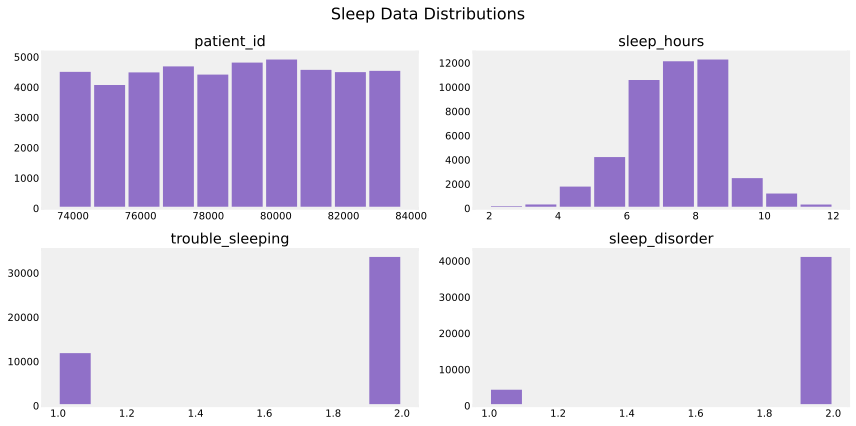

In [45]:
df_joined[sleep_features].hist(
    bins=10,
    figsize=(12, 6),
    grid = False,
    rwidth = 0.9,
    alpha=0.7,
    color=random.choice(hex_colors)
)
pl.suptitle("Sleep Data Distributions", fontsize=16)
plt.tight_layout()
plt.show()

As expected, we see a uniform distribution for the patient id. We can see a normal distribution for the number of hours that participants slept, and we can see that most of the participants not not report trouble sleeping or having a sleep disorder. 

We can also use the pandas builtin functions for plotting - for example we can also understand the mean, Q1, Q3, Min, Max, and outliers using a boxplot: 

<AxesSubplot:>

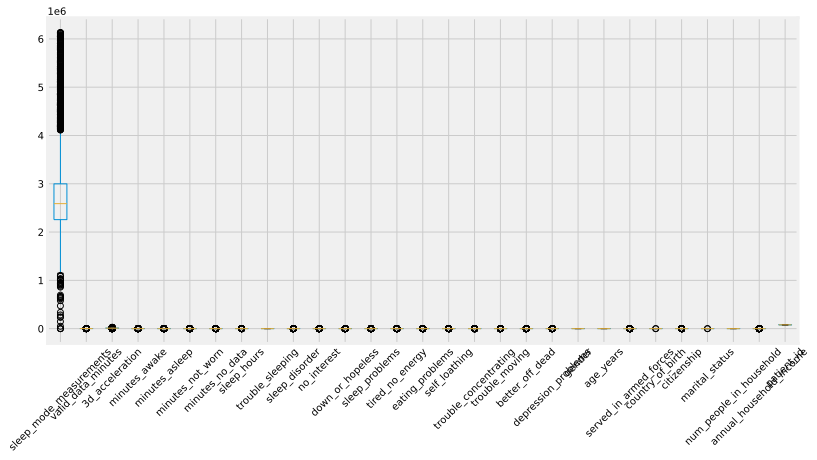

In [46]:
fig, axs = plt.subplots(figsize=(12, 6))
df_grouped.boxplot(rot=45)

### Scale the data for boxplot

We can see that the values of some features range up to $2.5 \cdot 10^7$, so we can use a min-max scalar to produce scaled data that we can then visualize using the same type of boxplot:

In [47]:
# df_joined_numeric = df_grouped[numeric_cols]
# # define min max scaler
# scaler = MinMaxScaler()
# # transform data
# df_scaled = scaler.fit_transform(df_joined_numeric)
# df_scaled = pd.DataFrame(df_scaled, columns=numeric_cols)
# df_scaled.head()

# fig, axs = plt.subplots(figsize=(12, 6))
# df_scaled.boxplot(rot=45)

We can see here that the sleep data values are all relatively small and show little variance compared with the physical activity data. This is expected because the sleep data is the result of surveys while the physical activity data was collected from sensors. 

# A deeper look at 3D acceleration 

We can see that 3D acceleration measures movement, which is a proxy for physical activity. Joining this signal with sleep data allows us to investigate a few interesting questions: 

1. Does more exercise mean more sleep?
2. Does more exercise mean fewer reported sleep disorders? 

To answer these questions visually, we want to understand how these two variales move together. To do this, we can group the 3d_acceleration data by patient_id and take the mean or the sum, then create a scatter plot of those values against various sleep values. We can look at the $R^2$ value of a line of best fit to see if there is any significant correlation between more physical activity and more sleep, or fewer reported sleep disorders. 

In [48]:
if phys_data == 'minute':
    pass
elif phys_data == 'hour':
    df = df_joined[['patient_id', '3d_acceleration', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']]
    df_grouped = df.groupby(['patient_id'])[['3d_acceleration', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']].mean()
    df_grouped = df_grouped.reset_index()
    df_grouped.head()
else:
    raise Exception(f'phys_data should be either \'minute\' or \'hour\', not {phys_data}')

In [49]:
def plot_acceleration_vs_sleep_hours(df: pd.DataFrame):
    fig, axs = plt.subplots(figsize=(12, 8))
    
    df = df[['patient_id', '3d_acceleration', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder', 'minutes_awake']]
    df_grouped = df.groupby(['patient_id'])[['3d_acceleration', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder', 'minutes_awake']].mean()
    df_grouped = df_grouped.reset_index()
    
    x = df_grouped['3d_acceleration']
    y = df_grouped['minutes_awake']
    
    #find line of best fit
    a, b = np.polyfit(x, y, 1)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    r_squared = r_value**2

    plt.scatter(x, y, c=random.choice(hex_colors), alpha=0.5)
    
    #add line of best fit to plot
    plt.plot(x, a*x+b, color='red', linewidth=1.5)  
    
    # annotate the plot with the information we have
    plt.text(21500, 550, f'Best Fit: y = {round(b, 3)} + {round(a, 3)}x', size=12)
    plt.text(21500, 500, f'R Squared: {round(r_squared, 4)}', size=12)
    plt.text(21500, 450, f'P Value: {round(p_value, 15)}', size=12)
    
    plt.xlabel("Aggregate 3D_Acceleration")
    plt.ylabel("Minutes Awake")
    plt.title(f'3D_Acceleration (Activity) vs. Minutes Awake', fontsize=16)
    plt.show()

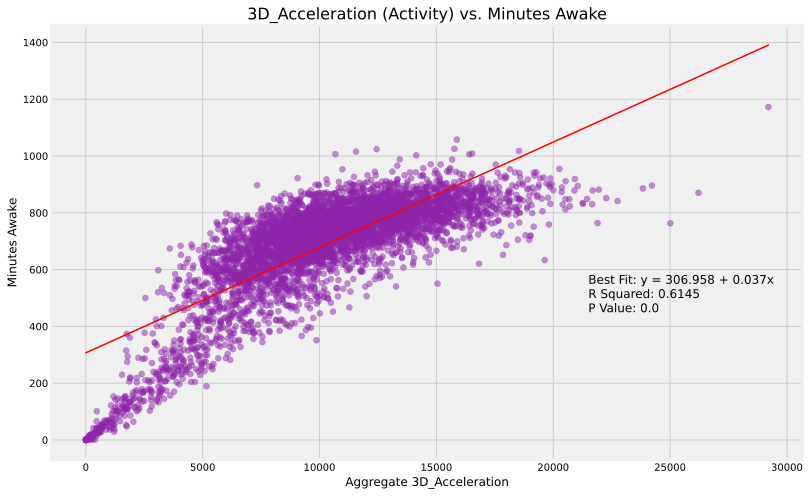

In [50]:
if phys_data == 'minute':
    pass
elif phys_data == 'hour':
    plot_acceleration_vs_sleep_hours(df=df_joined)
else:
    raise Exception(f'phys_data should be either \'minute\' or \'hour\', not {phys_data}')

So we can see here that there is no relationship between the amount of x, y, z acceleration on the wrist and the number of sleep hours that someone reports. Now we can investigate whether or not 'activity' impacts the prevelance of a sleep disorder:

In [51]:
if phys_data == 'minute':
    pass
elif phys_data == 'hour':
    df_grouped[df_grouped['trouble_sleeping'] == 1][['3d_acceleration', 'trouble_sleeping']].head()
else:
    raise Exception(f'phys_data should be either \'minute\' or \'hour\', not {phys_data}')

In [52]:
def plot_acceleration_vs_sleep_disorder(df: pd.DataFrame, sleep_metric: str):
    
    df = df[['patient_id', '3d_acceleration', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']]
    df_grouped = df.groupby(['patient_id'])[['3d_acceleration', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']].mean()
    df_grouped = df_grouped.reset_index()
    
    # generate the columns we need
    df_grouped['yes'] = 'yes'
    df_grouped['no'] = 'no'
    df_grouped['trouble_sleeping'] = np.where(df_grouped['trouble_sleeping'] == 1, df_grouped['yes'], df_grouped['no'])
    df_grouped['sleep_disorder'] = np.where(df_grouped['sleep_disorder'] == 1, df_grouped['yes'], df_grouped['no'])
    
    df1_reduced = df_grouped[['3d_acceleration', 'trouble_sleeping']]
    df2_reduced = df_grouped[['3d_acceleration', 'sleep_disorder']]
    
    f, axes = plt.subplots(1, 2, figsize = (10,8))
    sns.boxplot(x='trouble_sleeping',y='3d_acceleration', hue='trouble_sleeping',  data=df1_reduced, ax=axes[0])
    sns.boxplot(x='sleep_disorder',y='3d_acceleration', hue='sleep_disorder',  data=df2_reduced, ax=axes[1])
    plt.suptitle('\n Activity and Reported Sleep Disorders',fontsize=16)
    

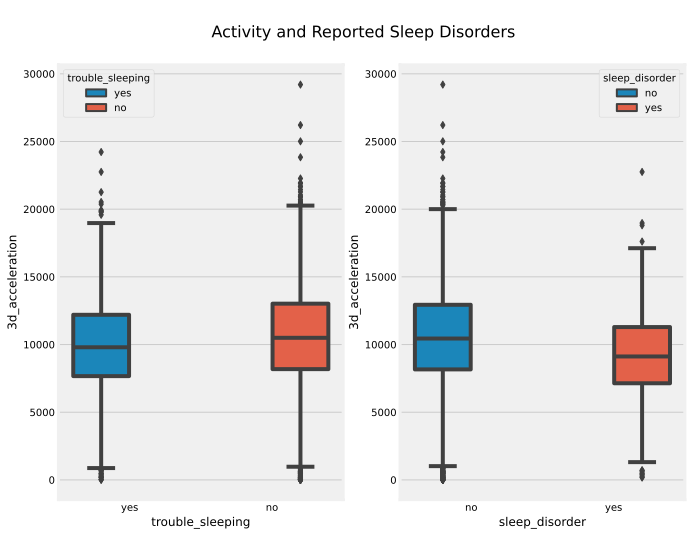

In [53]:
if phys_data == 'minute':
    pass
elif phys_data == 'hour':
    plot_acceleration_vs_sleep_disorder(df=df_joined, sleep_metric='trouble_sleeping')
else:
    raise Exception(f'phys_data should be either \'minute\' or \'hour\', not {phys_data}')

So an interesting result - it looks like people who get a little bit more physical activity are also the ones who are reporting more sleep disorders and trouble sleeping. It will take some more analysis to see whether or not this relationship is significant or causal, but it's interesting to simply separate the groups and observe their differences using a subplotted box plot like this. 

# Sandbox

In [54]:
a = np.array([[0.3, 0.4, 0.2 , 0.1], [0.2, 0.3, 0.5, 0], [0.1, 0, 0.8, 0.1], [0.4, 0, 0, 0.6]])

In [55]:
a = a*0.9
a

array([[0.27, 0.36, 0.18, 0.09],
       [0.18, 0.27, 0.45, 0.  ],
       [0.09, 0.  , 0.72, 0.09],
       [0.36, 0.  , 0.  , 0.54]])

In [56]:
identity = np.identity(4)
identity

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [57]:
a = identity - a
a

array([[ 0.73, -0.36, -0.18, -0.09],
       [-0.18,  0.73, -0.45,  0.  ],
       [-0.09,  0.  ,  0.28, -0.09],
       [-0.36,  0.  ,  0.  ,  0.46]])

In [58]:
b = np.array([3.1, 4.3, 5.9, 6.8])

In [59]:
x = np.linalg.solve(a, b)

In [60]:
x

array([49.71913868, 51.62938299, 54.31112138, 53.69323896])

 0.73 & -0.36 & -0.18 & -0.09
-0.18 &  0.73 & -0.45 &  0.0  
-0.09 &  0.0  &  0.28 & -0.09
-0.36 &  0.0  &  0.0  &  0.46